In [27]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [1]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [ ]:
!jt -r


In [17]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sbn 
import datetime
from DR_generator import *
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

# import jtplot module in notebook
#from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
#jtplot.style(theme='onedork')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
#jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
#jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

jtplot.reset()

# Summary 

The purpose of this script is to generate a dataset that we can use to test the impact of replicates on AUC measurements. 

#### Step 1: Generate non-hermetic dataset with replicates n=1:5 

#### Step 2: Calculate AUC of underlying curve 

#### Step 3: Fit logistic regression curve to data and calculate AUC 

#### Step 4: Compare error 
$$ error = AUC_{true} - AUC_{fitted} $$ 


In [133]:
batch_size = 500
noise = 0.15
nrepl = 6
plot=False

mygen1 = hermetic_generator(s = noise, b1range=(-10, -3), mrange= (0,0.5), b0range=(-7,-6), trange=(11,15), dose_points = [10/(3**i) for i in range(0,7)])
repl_data = mygen1.get(n=batch_size, nn=1, plot=plot)
print()

for n in range(2,nrepl): 
    mygen = hermetic_generator(s = noise, b1range=(-10, -3), mrange= (0,0.5), b0range=(-7,-6), trange=(11,15), dose_points = [10/(3**i) for i in range(0,7)])
    syn_data = mygen1.get(n=batch_size, nn=n, plot=plot)
    repl_data = repl_data.append(syn_data, ignore_index=True)
    print()

print(repl_data.shape)
repl_data.head()






(7500, 14)


,t,b1,b0,m,b,s,DOSE_10.00,DOSE_3.33,DOSE_1.11,DOSE_0.37,DOSE_0.12,DOSE_0.04,DOSE_0.01,id
0,13.219232,-4.504639,-6.328636,0.280197,-0.314147,0.15,0.015419,-0.010400,-0.154213,0.196796,0.022144,0.377777,0.890051,MT19937_23:12:42.242277_1
1,12.213676,-6.437860,-6.193643,0.268672,-0.292003,0.15,0.224802,0.037673,0.076463,-0.130597,0.505787,0.913357,0.885772,MT19937_23:12:42.244271_1
2,14.050717,-6.565876,-6.599890,0.363889,-0.417634,0.15,0.110571,0.273553,-0.267013,0.122237,0.311100,1.050987,1.104240,MT19937_23:12:42.246264_1
3,11.366002,-8.890423,-6.536449,0.303312,-0.320178,0.15,0.096395,-0.220637,0.139256,0.394818,1.029147,1.024779,0.884732,MT19937_23:12:42.248259_1
4,12.192643,-7.906057,-6.805176,0.203403,-0.220915,0.15,-0.087659,0.042297,-0.245372,0.069371,0.559955,1.152406,1.044720,MT19937_23:12:42.250253_1


In [134]:
def logistic_AUC(b0, b1, lower=10/3**6, upper=10, delta=0.001): 
    '''
    integrating the logistic equation, we calculate the closeform solution to get AUC from min conc (lower) to max conc (upper) given a pair of parameters. 
    
    P_i(c) =   1/(1+exp(-(b0 + b1*c)))
        where, 
            c = concentration 
            b0 = intercept param. 
            b1 = slope param.
    '''
    #logit = lambda x: 1/(1 + np.exp(-(b0 + b1*x)))
    #x = np.arange(lower, upper, delta)
    
    AUC = 0
    for x in np.arange(np.log10(lower), np.log10(upper), delta): AUC += (1/(1 + np.exp(-(b0 + b1*(x)))))*delta
    #AUC = np.sum(logit(x)*delta)
    #AUC = (upper - np.log(np.exp(b1*upper-b0) + 1)/b1) - (lower - np.log(np.exp(b1*lower-b0) + 1)/b1)
    return AUC 

In [135]:
repl_data = repl_data.assign(AUC_true = lambda x: logistic_AUC(x.b0, x.b1))
repl_data.head()

,t,b1,b0,m,b,s,DOSE_10.00,DOSE_3.33,DOSE_1.11,DOSE_0.37,DOSE_0.12,DOSE_0.04,DOSE_0.01,id,AUC_true
0,13.219232,-4.504639,-6.328636,0.280197,-0.314147,0.15,0.015419,-0.010400,-0.154213,0.196796,0.022144,0.377777,0.890051,MT19937_23:12:42.242277_1,0.484825
1,12.213676,-6.437860,-6.193643,0.268672,-0.292003,0.15,0.224802,0.037673,0.076463,-0.130597,0.505787,0.913357,0.885772,MT19937_23:12:42.244271_1,0.901630
2,14.050717,-6.565876,-6.599890,0.363889,-0.417634,0.15,0.110571,0.273553,-0.267013,0.122237,0.311100,1.050987,1.104240,MT19937_23:12:42.246264_1,0.858590
3,11.366002,-8.890423,-6.536449,0.303312,-0.320178,0.15,0.096395,-0.220637,0.139256,0.394818,1.029147,1.024779,0.884732,MT19937_23:12:42.248259_1,1.128009
4,12.192643,-7.906057,-6.805176,0.203403,-0.220915,0.15,-0.087659,0.042297,-0.245372,0.069371,0.559955,1.152406,1.044720,MT19937_23:12:42.250253_1,1.002518


In [136]:
def calc_AUC_from_replicates(D, conc = [10/(3**i) for i in range(0,7)]): 
    '''
    1. Fit logistic equation 
    2. Calculate AUC 
    3. return AUC 
    
    D <data.frame> 
        Expects (repl, 7), with decreasing dose
    '''
    # AVG POINTS BEFORE APPLYING CEILING, otherwise, truncation will lead to underfitting 
    D = np.mean(D, axis=0).reshape(1,7) if D.shape[0] > 1 else D
    D = pd.DataFrame(D).rename({x:y for x,y in enumerate(conc)}, axis=1)
    D = pd.melt(D, var_name='conc', value_name='cell_viab')
    x = sm.add_constant(np.log10(D['conc'].values))
    
    y = np.array([max(min(x, 1), 0) for x in D['cell_viab'].values])

    
    try: 
        pr = sm.GLM(y, x, family=sm.families.Binomial(link=sm.families.links.logit()))
        res = pr.fit(disp=False)
    except: 
        #raise
        return None, (None, None) 
    
    return logistic_AUC(*res.params), res.params
    

In [137]:
key = ['t','b1','b0','m','b','s']
uniq = repl_data[key].drop_duplicates()

res = {x:[] for x in key + ['AUC_synth', 'replicates',  'b0_synth', 'b1_synth']}
for i,row in enumerate(uniq.values):
    print(f'fitting regressions [{np.round(100*i/uniq.shape[0], 2)}%]', end='\r')
    assay = repl_data[ [np.all(x == row) for x in repl_data[key].values] ] 
    replicates = assay.shape[0]
    D = assay.values[:,6:(6+7)]
    AUC, (b0, b1) = calc_AUC_from_replicates(D)
    [res[x].append(y) for x,y in zip(key + ['AUC_synth', 'replicates', 'b0_synth', 'b1_synth'], list(row) + [AUC, replicates,b0,b1])]

repl_data = pd.merge(repl_data, pd.DataFrame(res), on=key, how='left')

repl_data = repl_data.assign(se = lambda x: (x.AUC_true - x.AUC_synth)**2)
repl_data.head()


C:\anaconda-3.5.2.0\lib\site-packages\statsmodels\genmod\families\family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


,t,b1,b0,m,b,s,DOSE_10.00,DOSE_3.33,DOSE_1.11,DOSE_0.37,DOSE_0.12,DOSE_0.04,DOSE_0.01,id,AUC_true,AUC_synth,replicates,b0_synth,b1_synth,se
0,13.219232,-4.504639,-6.328636,0.280197,-0.314147,0.15,0.015419,-0.010400,-0.154213,0.196796,0.022144,0.377777,0.890051,MT19937_23:12:42.242277_1,0.484825,0.524007,1,-4.006552,-2.796682,0.001535
1,12.213676,-6.437860,-6.193643,0.268672,-0.292003,0.15,0.224802,0.037673,0.076463,-0.130597,0.505787,0.913357,0.885772,MT19937_23:12:42.244271_1,0.901630,1.046097,1,-1.643182,-1.865375,0.020871
2,14.050717,-6.565876,-6.599890,0.363889,-0.417634,0.15,0.110571,0.273553,-0.267013,0.122237,0.311100,1.050987,1.104240,MT19937_23:12:42.246264_1,0.858590,1.121450,1,-1.577522,-2.019479,0.069095
3,11.366002,-8.890423,-6.536449,0.303312,-0.320178,0.15,0.096395,-0.220637,0.139256,0.394818,1.029147,1.024779,0.884732,MT19937_23:12:42.248259_1,1.128009,1.438969,1,-1.193439,-2.814797,0.096696
4,12.192643,-7.906057,-6.805176,0.203403,-0.220915,0.15,-0.087659,0.042297,-0.245372,0.069371,0.559955,1.152406,1.044720,MT19937_23:12:42.250253_1,1.002518,1.036518,1,-4.320433,-5.220732,0.001156


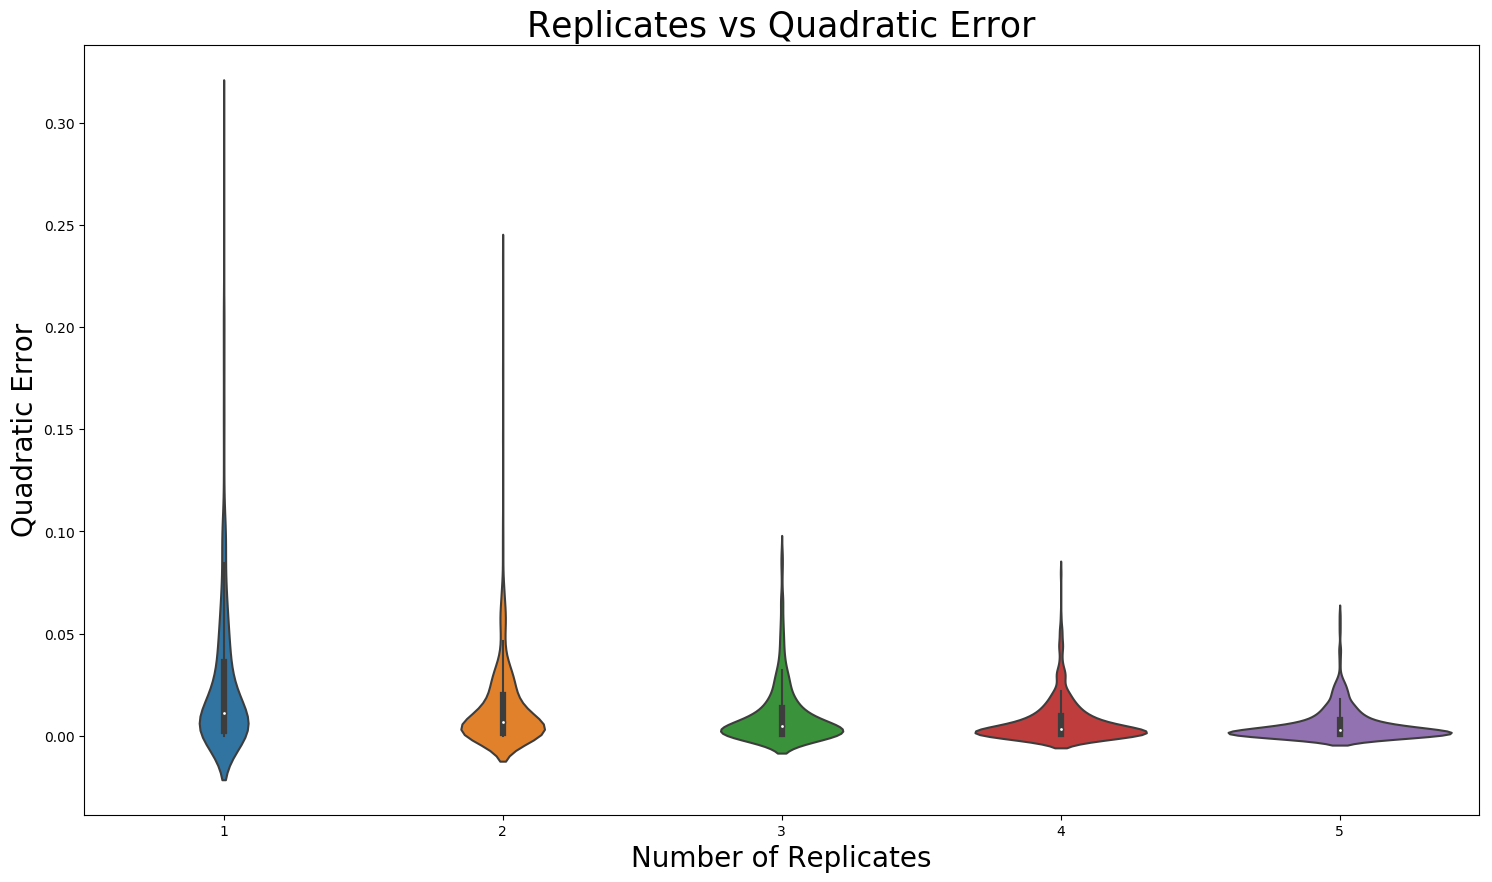

In [138]:
plt.figure(figsize=(18,10))
sbn.violinplot(x='replicates', y='se', data=repl_data[['replicates', 'se']].drop_duplicates())
plt.title('Replicates vs Quadratic Error',fontsize=25)
plt.ylabel('Quadratic Error',fontsize=20)
plt.xlabel('Number of Replicates',fontsize=20)
plt.show()

In [139]:
mse = repl_data[['replicates', 'se']].drop_duplicates().groupby('replicates').mean()['se']
mse

replicates
1    0.025539
2    0.014297
3    0.010319
4    0.007325
5    0.005701
Name: se, dtype: float64

[0.04239888 0.72476232 0.00488091] [[1.05128363e-05 2.57636696e-04 1.67871798e-06]
 [2.57636696e-04 8.64919676e-03 7.37871592e-05]
 [1.67871798e-06 7.37871592e-05 8.03447306e-07]]


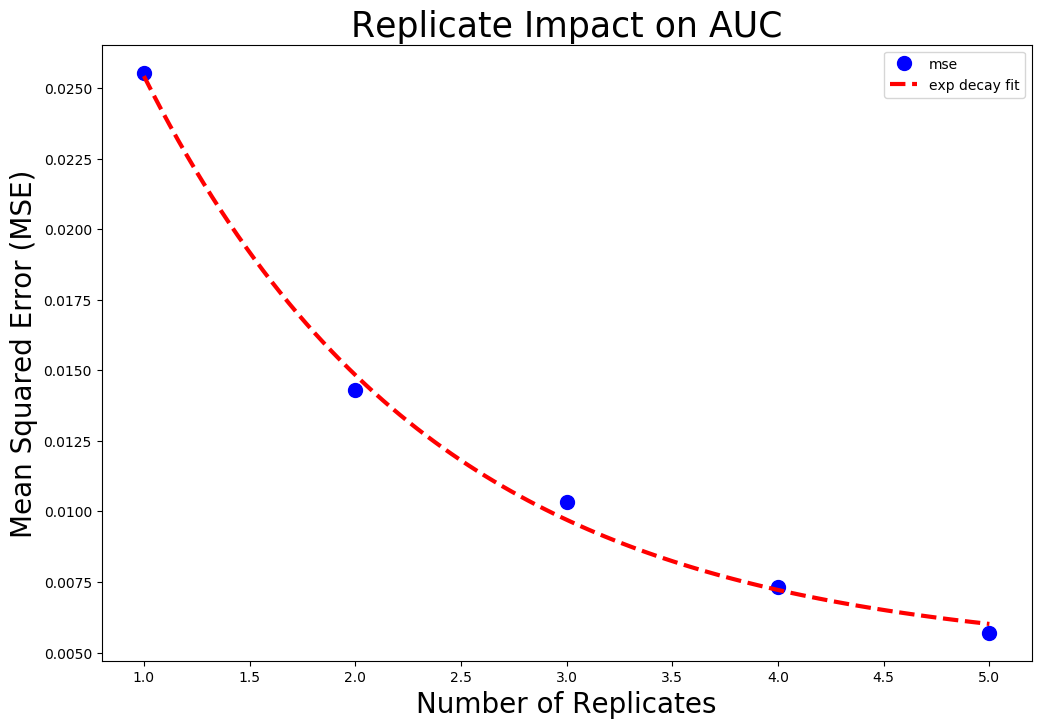

In [140]:
y = mse.values
x = np.arange(1,y.shape[0]+1)

from scipy.optimize import curve_fit

def func(x, a, b, c):
     return a*np.exp(-b*x) + c

#x = np.linspace(0,4,50)
#y = func(x, 2.5, 1.3, 0.5)
#yn = y + 0.2*np.random.normal(size=len(x))

popt, pcov = curve_fit(func, x, y)
print(popt, pcov)

x2 = np.linspace(1,y.shape[0],100)
y2 = func(x2, *popt)

plt.figure(figsize=(12,8))
plt.plot(x,y, 'bo', label='mse', markersize=10)
plt.plot(x2,y2, 'r--', label='exp decay fit', alpha=1, linewidth=3.0)
plt.xlabel('Number of Replicates',fontsize=20)
plt.ylabel('Mean Squared Error (MSE)',fontsize=20)
plt.title('Replicate Impact on AUC',fontsize=25)
plt.legend()
plt.show()


In [141]:
repl_data[['replicates', 'se']].drop_duplicates().groupby('replicates').count()

,se
replicates,
1,496
2,498
3,497
4,499
5,498


In [142]:
def plot_assay(D, lower=10/3**6, upper=10, delta=0.001, conc=[10/(3**i) for i in range(0,7)]): 
    '''
    '''
    b0 = D['b0'].unique()[0]
    b1 = D['b1'].unique()[0]
    b0s = D['b0_synth'].unique()[0]
    b1s = D['b1_synth'].unique()[0]
    
    logit = lambda x,b0,b1: 1/(1 + np.exp(-(b0 + b1*np.log10(x))))
    x = np.arange(lower, upper, delta)
    y = logit(x,b0,b1)
    y_synth = logit(x,b0s,b1s)
    
    df = pd.DataFrame(D.values[:, 6:(6+7)]).rename({x:y for x,y in zip(range(0,7), conc)}, axis=1).melt()
    conc = df['variable'].values
    cv = df['value'].values
    
    plt.figure(figsize=(12,8))
    plt.plot(np.log10(x),y,'r-',label='truth')
    plt.plot(np.log10(x),y_synth, 'b-', label='synth')
    plt.plot(np.log10(conc), cv, 'b*', label='replicates')
    plt.xlabel('log10(concentration)')
    plt.ylabel('cell_viability')
    plt.title(f'Regression Comparison [n_repl: {D.shape[0]}]')
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    
    

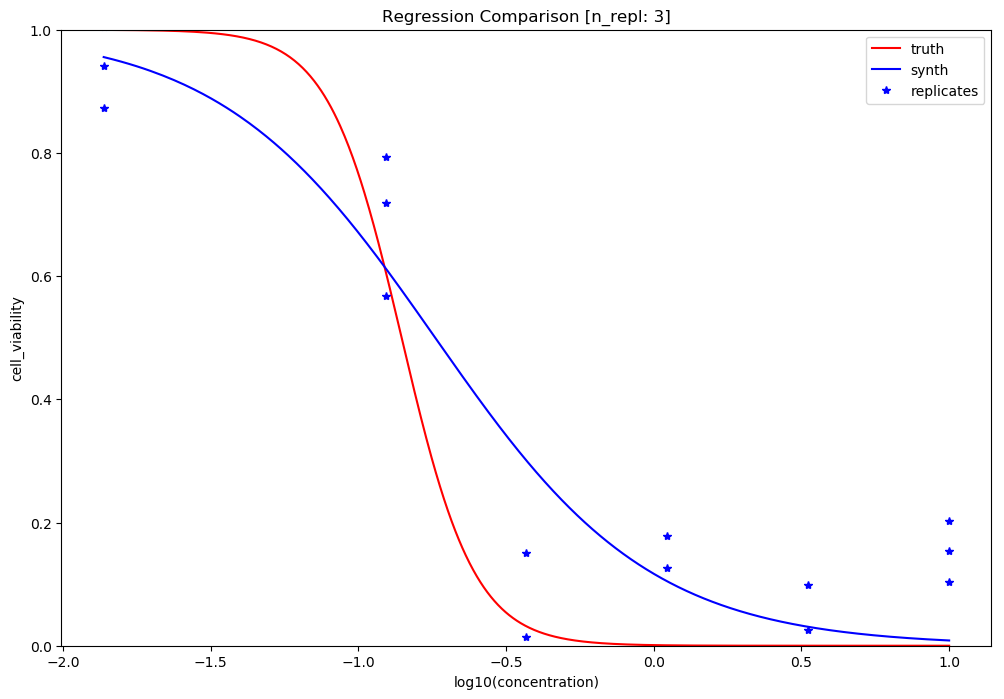

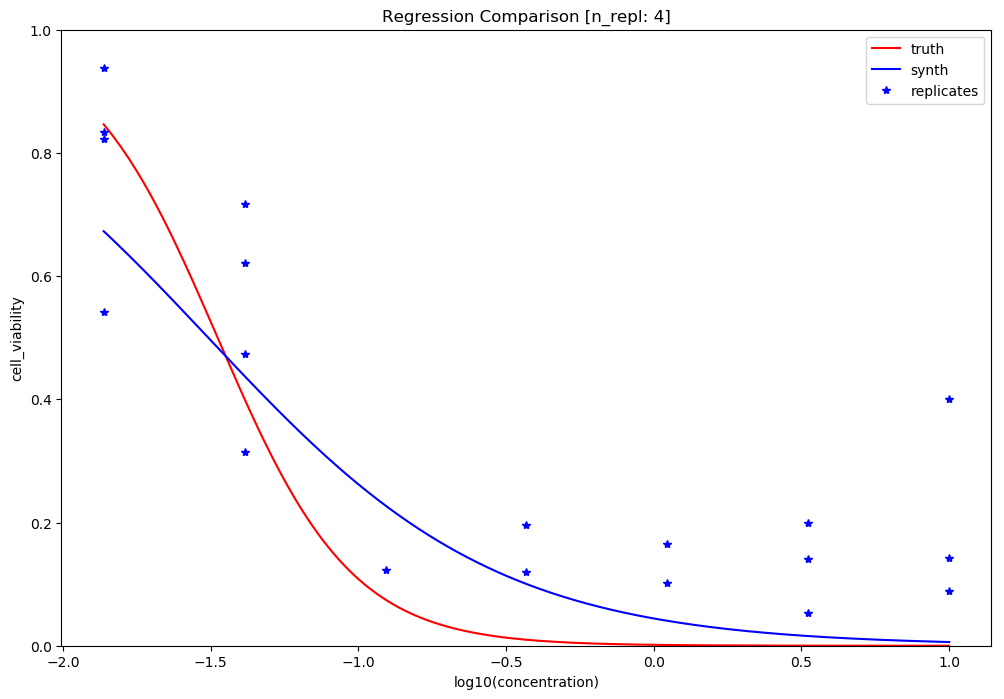

In [143]:
key = ['t','b1','b0','m','b','s']
uniq = repl_data[key].drop_duplicates().sample(frac=0.001).reset_index(drop=True)
#print(uniq)
for i,row in enumerate(uniq.values):
    assay = repl_data[ [np.all(x == row) for x in repl_data[key].values] ] 
    #print(assay)
    plot_assay(assay)

# Replicate effect on misclassification by tail-assignment 

Next, we'll use the tail-assignment to label sensitivity designations and compare misclassifications between our synthetic AUC and real AUC. 

This is only an estimation of misclassfication error, as a normal inhibitor distribution will likely have more structure then randomly sampled points. 

In [144]:
repl_data.head()

,t,b1,b0,m,b,s,DOSE_10.00,DOSE_3.33,DOSE_1.11,DOSE_0.37,DOSE_0.12,DOSE_0.04,DOSE_0.01,id,AUC_true,AUC_synth,replicates,b0_synth,b1_synth,se
0,13.219232,-4.504639,-6.328636,0.280197,-0.314147,0.15,0.015419,-0.010400,-0.154213,0.196796,0.022144,0.377777,0.890051,MT19937_23:12:42.242277_1,0.484825,0.524007,1,-4.006552,-2.796682,0.001535
1,12.213676,-6.437860,-6.193643,0.268672,-0.292003,0.15,0.224802,0.037673,0.076463,-0.130597,0.505787,0.913357,0.885772,MT19937_23:12:42.244271_1,0.901630,1.046097,1,-1.643182,-1.865375,0.020871
2,14.050717,-6.565876,-6.599890,0.363889,-0.417634,0.15,0.110571,0.273553,-0.267013,0.122237,0.311100,1.050987,1.104240,MT19937_23:12:42.246264_1,0.858590,1.121450,1,-1.577522,-2.019479,0.069095
3,11.366002,-8.890423,-6.536449,0.303312,-0.320178,0.15,0.096395,-0.220637,0.139256,0.394818,1.029147,1.024779,0.884732,MT19937_23:12:42.248259_1,1.128009,1.438969,1,-1.193439,-2.814797,0.096696
4,12.192643,-7.906057,-6.805176,0.203403,-0.220915,0.15,-0.087659,0.042297,-0.245372,0.069371,0.559955,1.152406,1.044720,MT19937_23:12:42.250253_1,1.002518,1.036518,1,-4.320433,-5.220732,0.001156


[0.4492252610085493, 1.1198751030872134, 0.537248918301094, 1.1409360192959388]


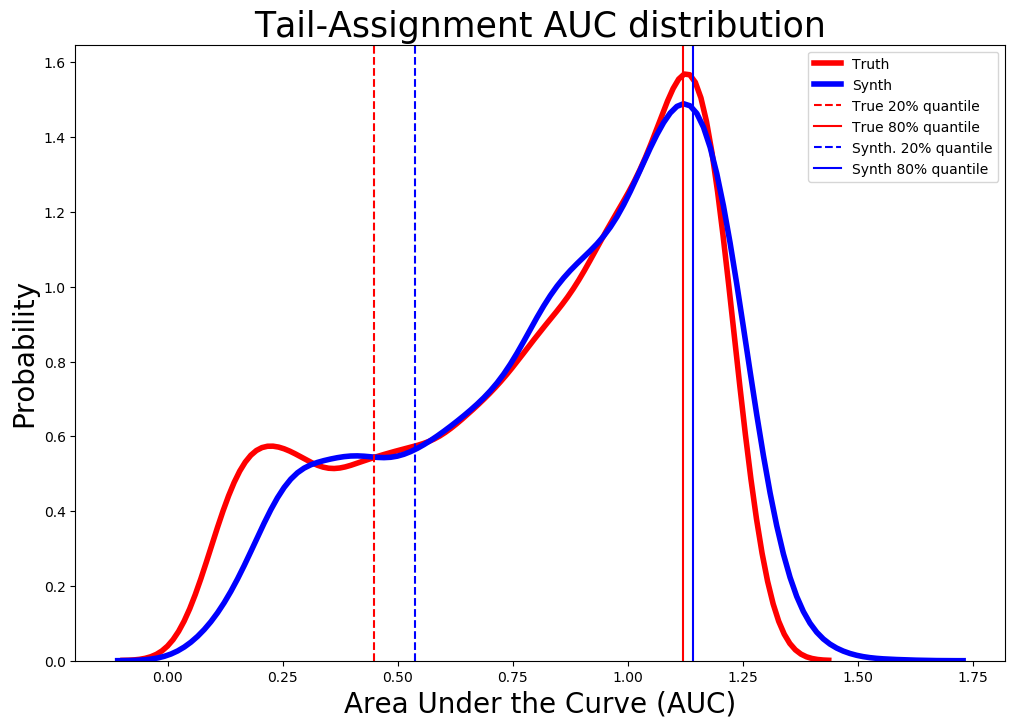

In [145]:
tAUC = repl_data.AUC_true.dropna()
sAUC = repl_data.AUC_synth.dropna()

tSens, tRes = np.quantile(tAUC, [0.2, 0.8])
sSens, sRes = np.quantile(sAUC, [0.2, 0.8])

print([tSens, tRes, sSens, sRes])

plt.figure(figsize=(12,8))
sbn.distplot(tAUC, label='Truth', color='red', hist=False, kde_kws=dict(linewidth=4))
sbn.distplot(sAUC, label='Synth', color='blue', hist=False, kde_kws=dict(linewidth=4))
plt.title('Tail-Assignment AUC distribution', fontsize=25)
plt.xlabel('Area Under the Curve (AUC)', fontsize=20)
plt.ylabel('Probability', fontsize=20)

plt.axvline(x=tSens, color='r', linestyle='--', label='True 20% quantile')
plt.axvline(tRes, color='r', linestyle='-', label='True 80% quantile')

plt.axvline(sSens, color='b', linestyle='--', label='Synth. 20% quantile')
plt.axvline(sRes, color='b', linestyle='-', label='Synth 80% quantile')

plt.legend()
plt.show()

In [146]:
tAssign = [] 
for tAUC in repl_data.AUC_true: 
    if tAUC < tSens: 
        tAssign.append('sens')
    elif tAUC > tRes: 
        tAssign.append('res')
    else: 
        tAssign.append('int')
        
sAssign = [] 
for sAUC in repl_data.AUC_synth: 
    if sAUC < sSens: 
        sAssign.append('sens')
    elif sAUC > sRes: 
        sAssign.append('res')
    else: 
        sAssign.append('int')

repl_data = repl_data.assign(true_assignment = tAssign, synth_assignment = sAssign)

In [147]:
repl_data.head()

repl_acc = []
for n in repl_data.replicates.unique(): 
    dat = repl_data[repl_data.replicates == n][['true_assignment', 'synth_assignment']]
    nn = dat.shape[0]
    repl_acc.append( np.sum([1 if x==y else 0 for x,y in zip(dat.true_assignment, dat.synth_assignment)])/nn )
    
print(repl_acc) 
   

[0.794, 0.834, 0.848, 0.894, 0.898]


[0.7732 0.0268]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     55.42
Date:                Mon, 04 Nov 2019   Prob (F-statistic):            0.00502
Time:                        23:14:51   Log-Likelihood:                 16.560
No. Observations:                   5   AIC:                            -29.12
Df Residuals:                       3   BIC:                            -29.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7732      0.012    

C:\anaconda-3.5.2.0\lib\site-packages\statsmodels\stats\stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


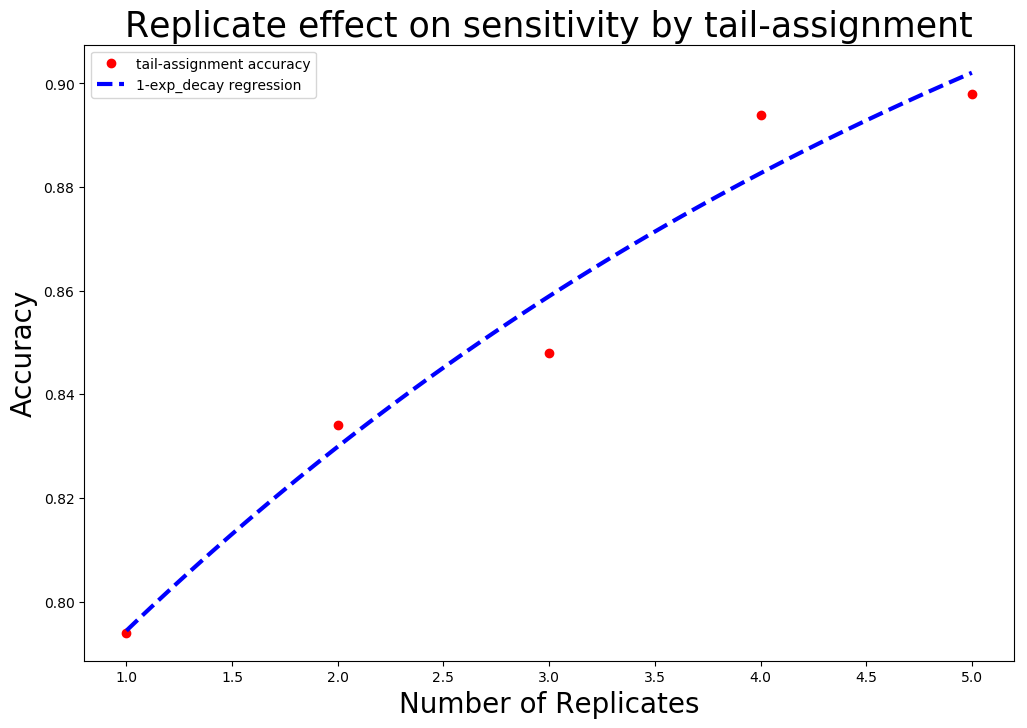

In [148]:
x = sm.add_constant(range(1,len(repl_acc)+1))
y = repl_acc

results = sm.OLS(y,x).fit()

print(results.params)

print(results.summary())


y = np.array(repl_acc)
x = np.arange(1,y.shape[0]+1)

def func(x, a, b, c):
     return 1 - a*np.exp(-b*x) + c

popt, pcov = curve_fit(func, x, y)

x2 = np.linspace(1,y.shape[0],100)
y2 = func(x2, *popt)

#xx = np.arange(1,len(repl_acc)+1, 0.1)
#yy = xx*results.params[1] + results.params[0]

plt.figure(figsize=(12,8))
plt.plot(range(1,len(repl_acc)+1),repl_acc,  'ro', label='tail-assignment accuracy')
plt.plot(x2,y2, 'b--', label=f'1-exp_decay regression', linewidth=3.0, markersize=20)
plt.xlabel('Number of Replicates', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Replicate effect on sensitivity by tail-assignment', fontsize=25)
plt.legend()
plt.show()

# Bayesian Dose Response Analysis 

Now we'll compare the results of our bayesian method to this, to see if it performs any better. 

In [149]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'C:\\Users\\natha\\Documents\\bayesian_dose_response\\python')
import bayesian_doseresponse_analysis as bdr  

In [150]:
repl_data.shape

(7500, 22)

In [151]:
noise = 0.15*100 # This should be matched to the noise we used above! but scaled to 100 for comparison to beatAML
n_controls = 21

bdr_dat = repl_data.assign(lab_id = [str(x).strip(' ') for x in repl_data[repl_data.columns[0:6]].values] )[list(repl_data.columns[6:6+7]) + ['AUC_true','AUC_synth', 'replicates', 'true_assignment', 'synth_assignment', 'lab_id']]
bdr_dat = bdr_dat.assign(inhibitor='sim_inhib')
bdr_dat.columns.values[0:0+7] = [float(x[5:]) for x in bdr_dat.columns[0:0+7]]
bdr_dat = bdr_dat.melt(id_vars=bdr_dat.columns[7:], value_vars=bdr_dat.columns[0:0+7], var_name='well_concentration', value_name='cell_viab')
bdr_dat = bdr_dat.assign(normalized_viability = lambda x: x.cell_viab * 100)

# make our controls 
temp = {x:[] for x in ['lab_id', 'inhibitor', 'normalized_viability']}
for labid in bdr_dat.lab_id.unique(): 
    temp['normalized_viability'] += np.random.normal(100, noise, n_controls).tolist()
    temp['lab_id'] += [labid]*n_controls
    temp['inhibitor'] += ['Control']*n_controls

temp = pd.DataFrame(temp)
#print(temp)
temp.head()

bdr_dat = bdr_dat.append(temp, ignore_index=True, sort=False)
bdr_dat.tail()
#repl_data.head()

,AUC_true,AUC_synth,replicates,true_assignment,synth_assignment,lab_id,inhibitor,well_concentration,cell_viab,normalized_viability
104995,NaN,NaN,NaN,NaN,NaN,[13.0591544 -7.54144563 -6.41947458 0.218144...,Control,NaN,NaN,100.921784
104996,NaN,NaN,NaN,NaN,NaN,[13.0591544 -7.54144563 -6.41947458 0.218144...,Control,NaN,NaN,107.034822
104997,NaN,NaN,NaN,NaN,NaN,[13.0591544 -7.54144563 -6.41947458 0.218144...,Control,NaN,NaN,130.640917
104998,NaN,NaN,NaN,NaN,NaN,[13.0591544 -7.54144563 -6.41947458 0.218144...,Control,NaN,NaN,95.623745
104999,NaN,NaN,NaN,NaN,NaN,[13.0591544 -7.54144563 -6.41947458 0.218144...,Control,NaN,NaN,94.843538


In [152]:
warnings.filterwarnings("ignore", category=FutureWarning)
BDRA_sim = bdr.inhibitor(bdr_dat, 'sim_inhib')
dat = BDRA_sim.simulate(patient_plots = False, verbose = False, nsim=100, model_fit='logit')


WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance


C:\anaconda-3.5.2.0\lib\site-packages\statsmodels\genmod\families\family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior V

WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior V

WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior V

WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior Variance
WARNING! only 1 replicate: Posterior Variance = Prior V

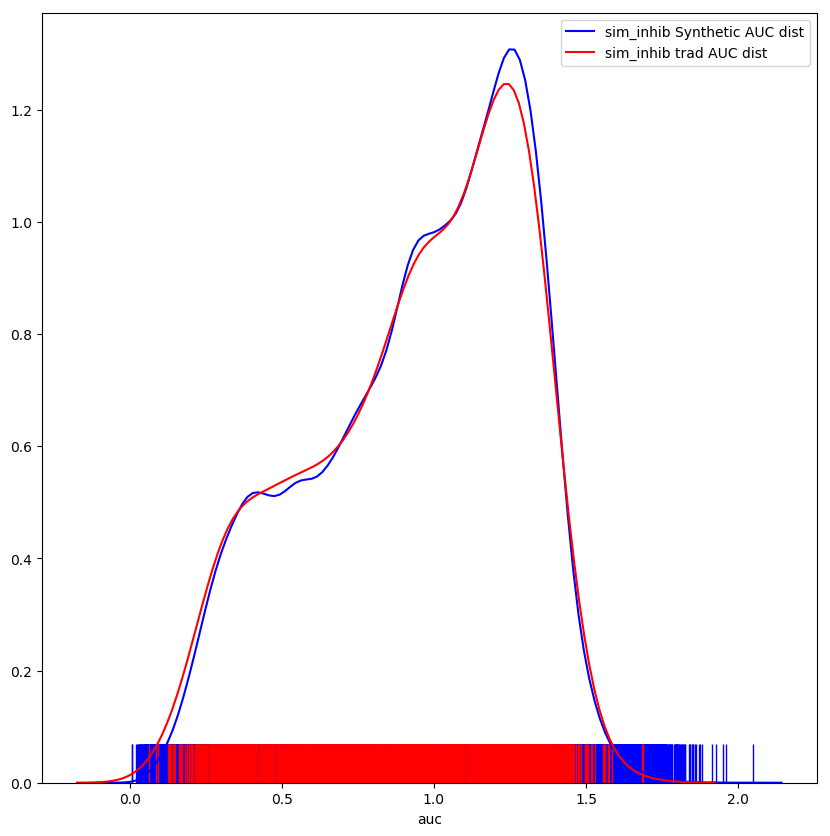

In [153]:
BDRA_sim.plot_inhibitor_auc_dist()

In [154]:
call_dat = BDRA_sim.get_sensitivity_designations(n_permute=1e5, verbose=True, plot=False, load_from_file=False, limit_plots=True)

Running permutations...[99.90%]
Permuation Testing [lab_id: [13.21923213 -4.50463917 -6.32863647  0.28019676 -0.31414692  0.15      ],  inhibitor: sim_inhib] P-Value [permutations: 100000]: 1.943E-02
number of patient aucs: 100
number of inhibitor aucs: 213600
Permuation Testing [lab_id: [12.21367571 -6.43785998 -6.19364331  0.26867181 -0.29200312  0.15      ],  inhibitor: sim_inhib] P-Value [permutations: 100000]: 7.520E-02
number of patient aucs: 100
number of inhibitor aucs: 213600
Permuation Testing [lab_id: [14.05071747 -6.56587554 -6.59988965  0.36388925 -0.41763443  0.15      ],  inhibitor: sim_inhib] P-Value [permutations: 100000]: 2.226E-02
number of patient aucs: 100
number of inhibitor aucs: 213600
Permuation Testing [lab_id: [11.36600186 -8.89042253 -6.53644937  0.30331178 -0.32017814  0.15      ],  inhibitor: sim_inhib] P-Value [permutations: 100000]: 0.000E+00
number of patient aucs: 100
number of inhibitor aucs: 213600
Permuation Testing [lab_id: [14.64040081 -6.40275182

In [155]:
call_dat.head()

,lab_id,inhibitor,p_value,mean_diff,auc,permutation_call,tail_assignment_call,avg_prob_monotonic,prob_decreasing,D1_P_atypical,D2_P_atypical,D3_P_atypical,D4_P_atypical,D5_P_atypical,D6_P_atypical,D7_P_atypical
0,[13.21923213 -4.50463917 -6.32863647 0.280196...,sim_inhib,0.01943,-0.282296,0.603817,sensitive,intermediate,0.612857,1.0,0.0,0.000000e+00,4.879430e-13,0.999770,9.535706e-13,9.980418e-01,0.697746
1,[12.21367571 -6.43785998 -6.19364331 0.268671...,sim_inhib,0.07520,0.215861,1.152088,intermediate,intermediate,0.501429,1.0,0.0,7.003797e-01,4.107825e-15,0.000000,9.999600e-01,2.299709e-01,0.999818
2,[14.05071747 -6.56587554 -6.59988965 0.363889...,sim_inhib,0.02226,0.276209,1.234475,resistant,intermediate,0.662857,1.0,0.0,1.241168e-01,0.000000e+00,0.000021,0.000000e+00,1.000000e+00,0.000205
3,[11.36600186 -8.89042253 -6.53644937 0.303311...,sim_inhib,0.00000,0.578787,1.571560,resistant,resistant,0.617143,1.0,0.0,9.914252e-01,5.296336e-01,0.000000,6.824262e-06,4.532212e-10,1.000000
4,[14.64040081 -6.40275182 -6.60095956 0.400575...,sim_inhib,0.72657,0.043476,0.964511,intermediate,intermediate,0.670000,1.0,0.0,9.409941e-08,0.000000e+00,0.999925,2.615685e-13,3.863859e-01,0.236999


In [156]:
rejected, adj_values, _, _  =  multipletests(call_dat['p_value'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
call_dat = call_dat.assign(adjusted_pvalue= adj_values)

In [157]:
call_dat = call_dat.assign(call_adjusted = ['int' if apv > 0.05 else 'res' if md > 0 else 'sens' for apv, md in zip(call_dat['adjusted_pvalue'], call_dat['mean_diff'])])

In [158]:
call_dat.head()

,lab_id,inhibitor,p_value,mean_diff,auc,permutation_call,tail_assignment_call,avg_prob_monotonic,prob_decreasing,D1_P_atypical,D2_P_atypical,D3_P_atypical,D4_P_atypical,D5_P_atypical,D6_P_atypical,D7_P_atypical,adjusted_pvalue,call_adjusted
0,[13.21923213 -4.50463917 -6.32863647 0.280196...,sim_inhib,0.01943,-0.282296,0.603817,sensitive,intermediate,0.612857,1.0,0.0,0.000000e+00,4.879430e-13,0.999770,9.535706e-13,9.980418e-01,0.697746,0.040022,sens
1,[12.21367571 -6.43785998 -6.19364331 0.268671...,sim_inhib,0.07520,0.215861,1.152088,intermediate,intermediate,0.501429,1.0,0.0,7.003797e-01,4.107825e-15,0.000000,9.999600e-01,2.299709e-01,0.999818,0.122616,int
2,[14.05071747 -6.56587554 -6.59988965 0.363889...,sim_inhib,0.02226,0.276209,1.234475,resistant,intermediate,0.662857,1.0,0.0,1.241168e-01,0.000000e+00,0.000021,0.000000e+00,1.000000e+00,0.000205,0.044814,res
3,[11.36600186 -8.89042253 -6.53644937 0.303311...,sim_inhib,0.00000,0.578787,1.571560,resistant,resistant,0.617143,1.0,0.0,9.914252e-01,5.296336e-01,0.000000,6.824262e-06,4.532212e-10,1.000000,0.000000,res
4,[14.64040081 -6.40275182 -6.60095956 0.400575...,sim_inhib,0.72657,0.043476,0.964511,intermediate,intermediate,0.670000,1.0,0.0,9.409941e-08,0.000000e+00,0.999925,2.615685e-13,3.863859e-01,0.236999,0.796691,int


In [159]:
bdr_dat2 = bdr_dat.merge(call_dat[['lab_id', 'call_adjusted']], on='lab_id', how='left')
bdr_dat2.head(5)

,AUC_true,AUC_synth,replicates,true_assignment,synth_assignment,lab_id,inhibitor,well_concentration,cell_viab,normalized_viability,call_adjusted
0,0.484825,0.524007,1.0,int,sens,[13.21923213 -4.50463917 -6.32863647 0.280196...,sim_inhib,10,0.015419,1.541918,sens
1,0.901630,1.046097,1.0,int,int,[12.21367571 -6.43785998 -6.19364331 0.268671...,sim_inhib,10,0.224802,22.480230,int
2,0.858590,1.121450,1.0,int,int,[14.05071747 -6.56587554 -6.59988965 0.363889...,sim_inhib,10,0.110571,11.057129,res
3,1.128009,1.438969,1.0,res,res,[11.36600186 -8.89042253 -6.53644937 0.303311...,sim_inhib,10,0.096395,9.639533,res
4,1.002518,1.036518,1.0,int,int,[12.19264329 -7.90605684 -6.80517605 0.203402...,sim_inhib,10,-0.087659,-8.765874,NaN


In [160]:
bdra_repl = []
n_na = 0
for n in range(1,len(repl_acc)+1): 
    df = bdr_dat2[bdr_dat2['replicates'] == n][['lab_id','replicates','true_assignment','call_adjusted']].drop_duplicates()
    n_na += np.sum([1*pd.isna(x) for x in df['call_adjusted']])
    df = df.dropna()
    acc = np.sum([1*(x==y) for x,y in zip(df['true_assignment'], df['call_adjusted'])]) / df.shape[0]
    bdra_repl.append(acc)

In [161]:
bdra_repl

[0.7630057803468208,
 0.8039647577092511,
 0.8418708240534521,
 0.8972602739726028,
 0.8418708240534521]

In [162]:
bdra_repl

[0.7630057803468208,
 0.8039647577092511,
 0.8418708240534521,
 0.8972602739726028,
 0.8418708240534521]

[1 2 3 4 5]
[0.76300578 0.80396476 0.84187082 0.89726027 0.84187082]


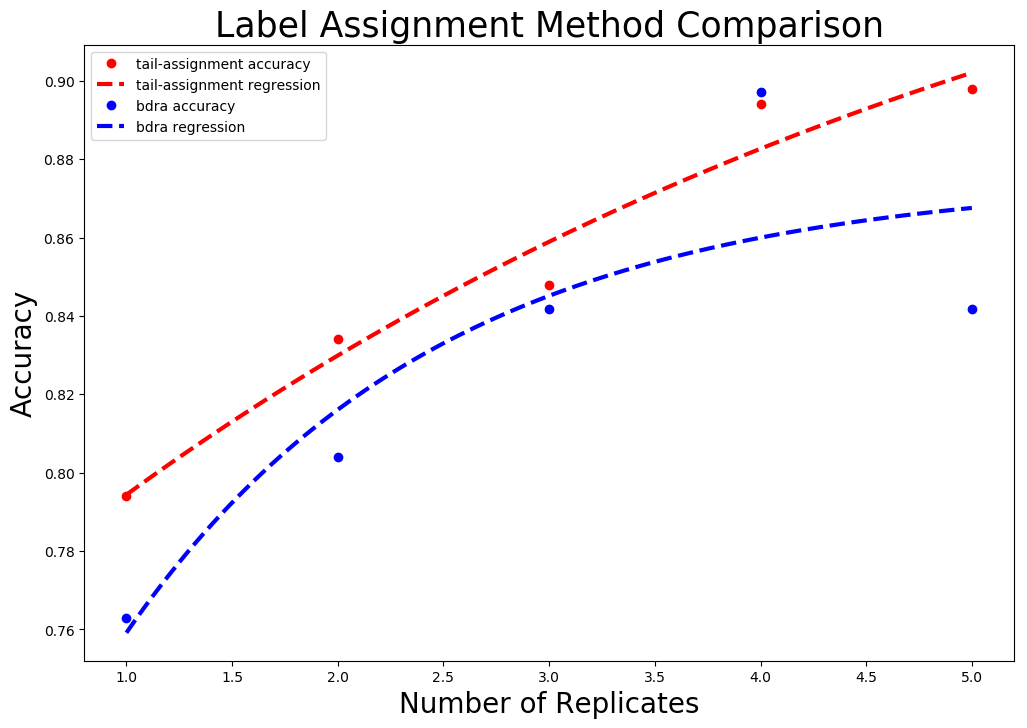

In [163]:
y = np.array(repl_acc)
x = np.arange(1,y.shape[0]+1)

def func(x, a, b, c):
     return 1 - a*np.exp(-b*x) + c

popt, pcov = curve_fit(func, x, y)

xx = np.linspace(1,y.shape[0],100)
yy = func(xx, *popt)

# ---------
y2 = np.array(bdra_repl)
x2 = np.arange(1,y2.shape[0]+1)
print(x2)
print(y2)

popt, pcov = curve_fit(func, x2, y2,method='lm')

xx2 = np.linspace(1,y2.shape[0],100)
yy2 = func(xx2, *popt)


plt.figure(figsize=(12,8))
plt.plot(range(1,len(repl_acc)+1),repl_acc,  'ro', label='tail-assignment accuracy')
plt.plot(xx,yy, 'r--', label=f'tail-assignment regression', linewidth=3)

plt.plot(range(1,len(repl_acc)+1),bdra_repl,  'bo', label='bdra accuracy')
plt.plot(xx2,yy2, 'b--', label=f'bdra regression', linewidth=3)

plt.xlabel('Number of Replicates', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Label Assignment Method Comparison', fontsize=25)
plt.legend()
plt.show()